In [984]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import curve_fit
import uncertainties as unc
from sympy.abc import *

In [985]:
def get_measurementsData(filenames, measurement_starting_indexes, measurement_last_indexes):
    t = []
    x = []
    v = []
    a = []
    for i in range(len(filenames)):
        filename = filenames[i]
        first_index = measurement_starting_indexes[i]
        last_index = measurement_last_indexes[i]

        df = pd.read_csv(filename, header=None)
        t.append(df.iloc[first_index:last_index, 3].to_numpy().astype(float))
        x.append(df.iloc[first_index:last_index, 5].to_numpy().astype(float))
        v.append(df.iloc[first_index:last_index, 7].to_numpy().astype(float))
        a.append(df.iloc[first_index:last_index, 9].to_numpy().astype(float))
    return t, x, v, a


measurement_starting_indexes = [130, 100, 60, 120, 70]
measurement_last_indexes = [270, 240, 220, 270, 220]
filenames = [
    './final_data/run1_height_4.csv', 
    './final_data/run2_height_4.csv',
    './final_data/run3_height_4.csv',
    './final_data/run4_height_4.csv',
    './final_data/run5_height_4.csv']

t, x, v, a = get_measurementsData(filenames, measurement_starting_indexes, measurement_last_indexes)
# merge all measurements into single np arrays
t_concatenated = np.concatenate((t))
x_concatenated = np.concatenate((x))
v_concatenated = np.concatenate((v))
a_concatenated = np.concatenate((a))

a_mean = np.mean(a_concatenated) # we want a to be constant always, therefore we take the mean from the whole population


In [986]:
def create_intervals(t, x, v, a, number_of_intervals_per_measurement):
    t_intervals = []
    x_intervals = []
    v_intervals = []
    a_intervals = []
    for measurement_no in range(len(t)):
        t_one_measurement = t[measurement_no]
        x_one_measurement = x[measurement_no]
        v_one_measurement = v[measurement_no]
        a_one_measurement = a[measurement_no]

        total_points = len(t_one_measurement)
        points_per_interval = total_points // number_of_intervals_per_measurement

        # Create n separate intervals
        t_intervals.extend([t_one_measurement[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)])
        x_intervals.extend([x_one_measurement[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)])
        v_intervals.extend([v_one_measurement[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)])
        a_intervals.extend([a_one_measurement[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)])
    return t_intervals, x_intervals, v_intervals, a_intervals

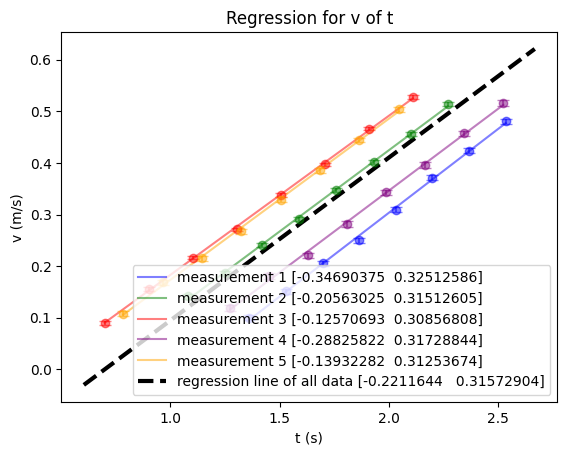

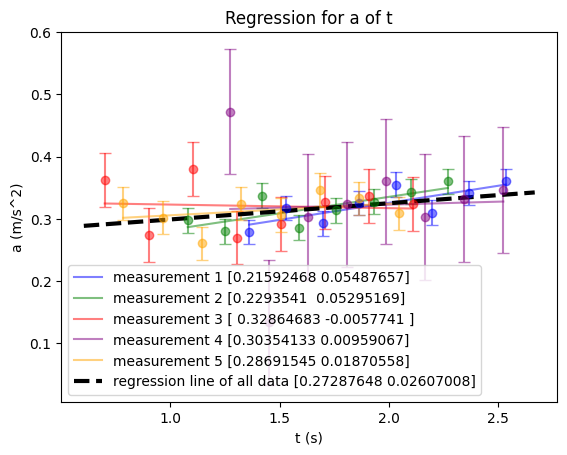

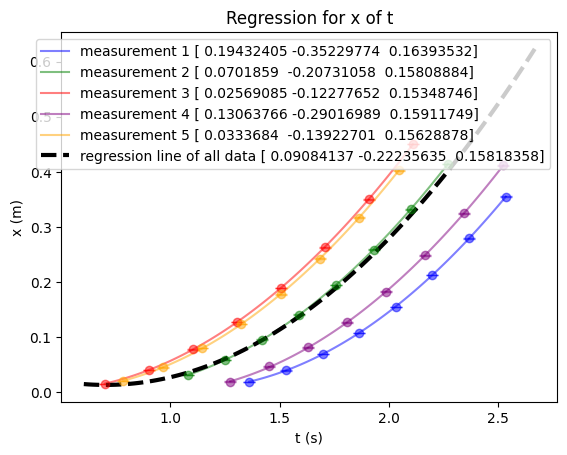

(0.0016152772676674525, 0.014873179994042376, 0.00019678424704471257)

In [987]:

number_of__chosen_measurement_intervals_for_error_analysis = 8
t_intervals, x_intervals, v_intervals, a_intervals = create_intervals(t, x, v, a, number_of__chosen_measurement_intervals_for_error_analysis)

def f_linear(x,A,B):
    return A+B*x
    
def f_parabolic(x,A,B,C):
    return A+B*x+C*x**2

def get_regression_params(f, x, y):
    param,cov = curve_fit(f,x, y)
    error = np.std(y-f_linear(x, *param),ddof=2)



def calculate_errors():
    def plot_measurement_error(x, y, f, title, x_label, y_label):
        plt.figure()
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        # plot measurements separately with different color
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        std_errors = []
        params_for_regression = []
        for measurement_no in range(len(x)):
            x_measurement = x[measurement_no]
            y_measurement = y[measurement_no]
            
            # plot chosen measurements
            param,cov = curve_fit(f, x_measurement, y_measurement)
            params_for_regression.append(param)
            std_error = np.std(y_measurement-f(x_measurement, *param),ddof=2)
            data_samples_no = math.sqrt(len(x[measurement_no]))
            std_errors.append(std_error/data_samples_no) # standard error of the mean should be devined by the square root of the number of data samples
            plt.errorbar(x_measurement,y_measurement,yerr=std_error,fmt='o',capsize=4, color=colors[measurement_no], alpha=0.5)

            #plot regression line for current measurement
            params,cov = curve_fit(f,x_measurement, y_measurement)
            x_values = np.linspace(min(x_measurement),max(x_measurement),100)
            plt.plot(x_values,f(x_values, *params), color=colors[measurement_no], alpha=0.5, label=f"measurement {measurement_no+1} {params}")

        # plot regression line for all measurements
        t_values = np.linspace(min(t_concatenated),max(t_concatenated),100)
        params = np.mean(params_for_regression, axis=0) # CECNTRAL LIMIT THEOREM
        plt.plot(t_values,f(t_values, *params),'--', color='black', linewidth=3, label=f"regression line of all data {params}")

        plt.legend()
        plt.show()

        # having the std errors for each measurement I know that their mean will approach the center of normal distribution based on the CENTRAL LIMIT THEOREM
        return np.mean(std_errors) # CENTRAL LIMIT THEOREM

    t_intervals, x_intervals, v_intervals, a_intervals = create_intervals(t, x, v, a, number_of__chosen_measurement_intervals_for_error_analysis)
    data_for_error_analysis = []
    for measurement_no in range(len(t)):
        measurement_data = []
        for interval_no_in_measurement in range(number_of__chosen_measurement_intervals_for_error_analysis):
            interval_no = measurement_no * number_of__chosen_measurement_intervals_for_error_analysis + interval_no_in_measurement
            measurement_data.append([np.mean(t_intervals[interval_no]), np.mean(x_intervals[interval_no]), np.mean(v_intervals[interval_no]), np.mean(a_intervals[interval_no])])
        data_for_error_analysis.append(measurement_data)
    data_for_error_analysis = np.array(data_for_error_analysis)


    # calculate errors and plot them
    # v by t    
    #param,cov = curve_fit(f_linear,t_concatenated, v_concatenated)
    #A = param[0]
    #B = param[1]
    #dv = np.std(v_concatenated-f_linear(t_concatenated, A, B),ddof=2)
    dv = plot_measurement_error(data_for_error_analysis[:,:,0], data_for_error_analysis[:,:,2], f_linear, "Regression for v of t", 't (s)', 'v (m/s)')

    # a by t
    #param,cov = curve_fit(f_linear,t_concatenated, a_concatenated)
    #A = param[0]
    #B = param[1]
    #da = np.std(a_concatenated-f_linear(t_concatenated, A, B),ddof=2)
    da = plot_measurement_error(data_for_error_analysis[:,:,0], data_for_error_analysis[:,:,3], f_linear, "Regression for a of t", 't (s)', 'a (m/s^2)')

    # x by t
    #param,cov = curve_fit(f_parabolic,t_concatenated, x_concatenated)
    #A = param[0]
    #B = param[1]
    #C = param[2]
    #dx = np.std(x_concatenated-f_parabolic(t_concatenated, A, B, C),ddof=3)
    dx = plot_measurement_error(data_for_error_analysis[:,:,0], data_for_error_analysis[:,:,1], f_parabolic, "Regression for x of t", 't (s)', 'x (m)')

    return dv, da,dx

dv, da, dx = calculate_errors()
dv, da, dx

#dv = [] 
#da = []
#dx = []
#for i in range(len(t)):
#    dv_i, da_i, dx_i = get_errors_for_one_measurement(t[i], x[i], v[i], a[i])
#    dv.append(dv_i)
#    da.append(da_i)
#    dx.append(dx_i)

In [988]:
#number_of_intervals_per_measurement=3
#t_intervals, x_intervals, v_intervals, a_intervals = create_intervals(t, x, v, a, number_of_intervals_per_measurement)
"""
This function takes data arrays and processes them into data groups which are plotted as individual points.
"""
def group_measurements_into_points():
    def calculate_pi_1(x, v, t):
        return (x[-1]-x[0]) / (v[0] * (t[-1]-t[0]))

    def calculate_pi_2(a_mean, v, t):
        return a_mean * (t[-1]-t[0]) / v[0]
    
    pi_1 = []
    pi_1_errors = []
    pi_2 = []
    pi_2_errors = []
    for i in range(len(t_intervals)):
        t_interval = t_intervals[i]
        x_interval = x_intervals[i]
        v_interval = v_intervals[i]
        
        t_initial_error = unc.ufloat(t_interval[0], 0)
        t_final_error = unc.ufloat(t_interval[-1], 0)
        x_initial_error = unc.ufloat(x_interval[0], dx)
        x_final_error = unc.ufloat(x_interval[-1], dx)
        v_initial_error = unc.ufloat(v_interval[0], dv)
        x_interval_with_error = [x_initial_error, x_final_error]
        t_interval_with_error = [t_initial_error, t_final_error]
        v_interval_with_error = [v_initial_error]

        pi1 = calculate_pi_1(x_interval_with_error, v_interval_with_error, t_interval_with_error)
        pi_1.append(pi1.nominal_value)
        pi_1_errors.append(pi1.std_dev)
        pi2 = calculate_pi_2(a_mean, v_interval_with_error, t_interval_with_error)
        pi_2.append(pi2.nominal_value)
        pi_2_errors.append(pi2.std_dev)
    
    return pi_1, pi_1_errors, pi_2, pi_2_errors

pi_1, pi_1_errors, pi_2, pi_2_errors = group_measurements_into_points()

# remove outliers
# assume that if std > 3, than it is an outlier and it should be removed
outlier_indexes = []
intervals_number = len(pi_1)
std_threshold = 3
for i in range(intervals_number):
    if pi_1_errors[i] > std_threshold or pi_2_errors[i] > std_threshold or pi_2[i]> 1.4:
        outlier_indexes.append(i)

pi_1 = [pi_1[i] for i in range(intervals_number) if i not in outlier_indexes]
pi_1_errors = [pi_1_errors[i] for i in range(intervals_number) if i not in outlier_indexes]
pi_2 = [pi_2[i] for i in range(intervals_number) if i not in outlier_indexes]
pi_2_errors = [pi_2_errors[i] for i in range(intervals_number) if i not in outlier_indexes]
intervals_number -= 1

A = 1.024+/-0.014
B = 0.44+/-0.05


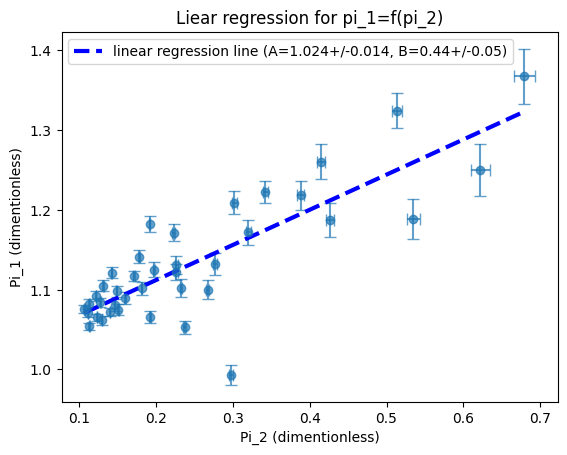

39


In [989]:

def plot_regression_with_errors():
    def f(x,A,B):
        return A+B*x
    param,cov = curve_fit(f,pi_2,pi_1)
    A = unc.ufloat(param[0],np.sqrt(np.diag(cov))[0])
    B = unc.ufloat(param[1],np.sqrt(np.diag(cov))[1])
    print('A = {}'.format(A))
    print('B = {}'.format(B))

    plt.figure()
    plt.xlabel("Pi_2 (dimentionless)")
    plt.ylabel("Pi_1 (dimentionless)")
    plt.title("Liear regression for pi_1=f(pi_2)")
    pi2_values = np.linspace(min(pi_2),max(pi_2),100)
    plt.errorbar(pi_2,pi_1, xerr=pi_2_errors, yerr=pi_1_errors, fmt='o', capsize=4, alpha=0.7)
    plt.plot(pi2_values, f(pi2_values, *param),'b--', label=f"linear regression line (A={A}, B={B})", linewidth=3)
    plt.legend()
    plt.show()

plot_regression_with_errors()
print(len(pi_1_errors))